In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

### Getting the data

In [54]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 12)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

### Pre-processing

In [55]:
bova11.columns = bova11.columns.str.lower()
bova11.date = pd.to_datetime(bova11.date)
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

In [56]:
# Adding columns

bova11["prev_close"] = bova11.shift(1)["close"]
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)

bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

100%|██████████| 3404/3404 [00:00<00:00, 10008.90it/s]

[[-0.39030025 -0.91719676 -0.95032594 ...         nan -0.78570428
  -0.8756999 ]
 [-0.35971966 -0.87970094 -0.91076644 ...         nan -0.79239236
  -0.86853306]
 [-0.33009474 -0.87255889 -0.86918409 ...         nan -0.83530725
  -0.90615904]
 ...
 [ 0.73146451  0.63709403  0.64036862 ...  0.26982232 -0.81106316
   0.6114222 ]
 [ 0.74388784  0.63486217  0.6032816  ...  0.13341511 -0.87292727
   0.56438976]
 [ 0.7120331   0.62169391  0.58080464 ... -0.04127008 -0.87571391
          nan]]


### Importing the functions

In [57]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [58]:
def feature_calc(df):
    # Adding close change
    df["prev_close"] = df.shift(1)["close"]
    df["close_change"]= df.progress_apply(
        lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
        axis = 1
    )
    # Adding move Averages columns
    df['ma_3d'] = df['close'].rolling(3, center = True, min_periods=1).mean()
    df['ma_10d'] = df['close'].rolling(10, center = True,min_periods=1).mean()
    df['ma_30d'] = df['close'].rolling(30, center=True, min_periods=1).mean()
    df['ma_60d'] = df['close'].rolling(60, center = True, min_periods = 1).mean()
    # Adding standard deviation columns
    df['std_7'] = df['close'].rolling(7, center = True, min_periods = 1).std()
    df['std_30'] = df['close'].rolling(30, center = True, min_periods = 1).std()
    df['std_60'] = df['close'].rolling(60, center = True, min_periods = 1).std()
    # Adding the bollinger bands
    df['upper3'] = df['ma_3d'] + 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['lower3'] = df['ma_3d'] - 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['upper30'] = df['ma_30d'] + 2*df['std_30']
    df['lower30'] = df['ma_30d'] - 2*df['std_30']
    df['upper60'] = df['ma_60d'] + 2*df['std_60']
    df['lower60'] = df['ma_60d'] - 2*df['std_60']
    # Adding tecnical indicator RSI
    df['RSI'] = ta.rsi(df['close'], length = 15)
    df['target'] = df.close - df.open
    df['targetNextClose'] = df['close'].shift(-1)
    
    return df

In [59]:
def predict(df, days, pass_days, model):
    # copy the dataframe to edit
    df_ = df.copy()
    
    for i in reversed(range(days+1)):
        if days > 0:
            # scale the features for the model prediction
            scaler = MinMaxScaler(feature_range = (-1, 1))
            df_scaled = scaler.fit_transform(df_)

            backcandles = pass_days #Defined by hyperparameters testing
            X = []
            for j in range(19): # range is the number of feature columns you will use
                X.append([])
                for k in range(backcandles, df_scaled.shape[0]):
                    X[j].append(df_scaled[k-backcandles:k, j])

            #move axis from 0 to position 2
            X = np.moveaxis(X, [0], [2])

            X, yi = np.array(X), np.array(df_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
            y = np.reshape(yi, (len(yi), 1))

            splitlimit = int(len(X) * 0.9)
            x_test = X[splitlimit+1:] # take the last 10% of the original database

            if days > 1:
                x_test = x_test[-days:-(days-1)] 
            else:
                x_test = x_test[-days:]
            
            y_pred = model.predict(x_test) # make the prediction on the day to replace
            #print(y_pred)
            #print(df_scaled[-days][3])
            df_scaled[-days][3] = y_pred[0]
            #print(df_scaled[-days][3])
            predict_value = scaler.inverse_transform(df_scaled)[-days][3]
            
            #print(df_.loc[(len(df_) - days) : (len(df_) - days)].close)
            df_.loc[(len(df_) - days) : (len(df_) - days), 'close'] = predict_value
            #print(df_.loc[(len(df_) - days) : (len(df_) - days)].close)
            
            df_ = feature_calc(df_)
            print(days)
            days = days -1
    
    return df_

### Creating the models

#### GRU

In [60]:
n_neurons = 256
n_batch_size = 32
dropout = 0.1
pass_days = 100

In [61]:
backcandles = pass_days
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for k in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[k-backcandles:k, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [62]:
from keras.models import load_model

model_gru = load_model('GRU/best_model.h5')
model_lstm = load_model('lstm/best_model.h5')

11/11 [==============================] - 4s 184ms/step


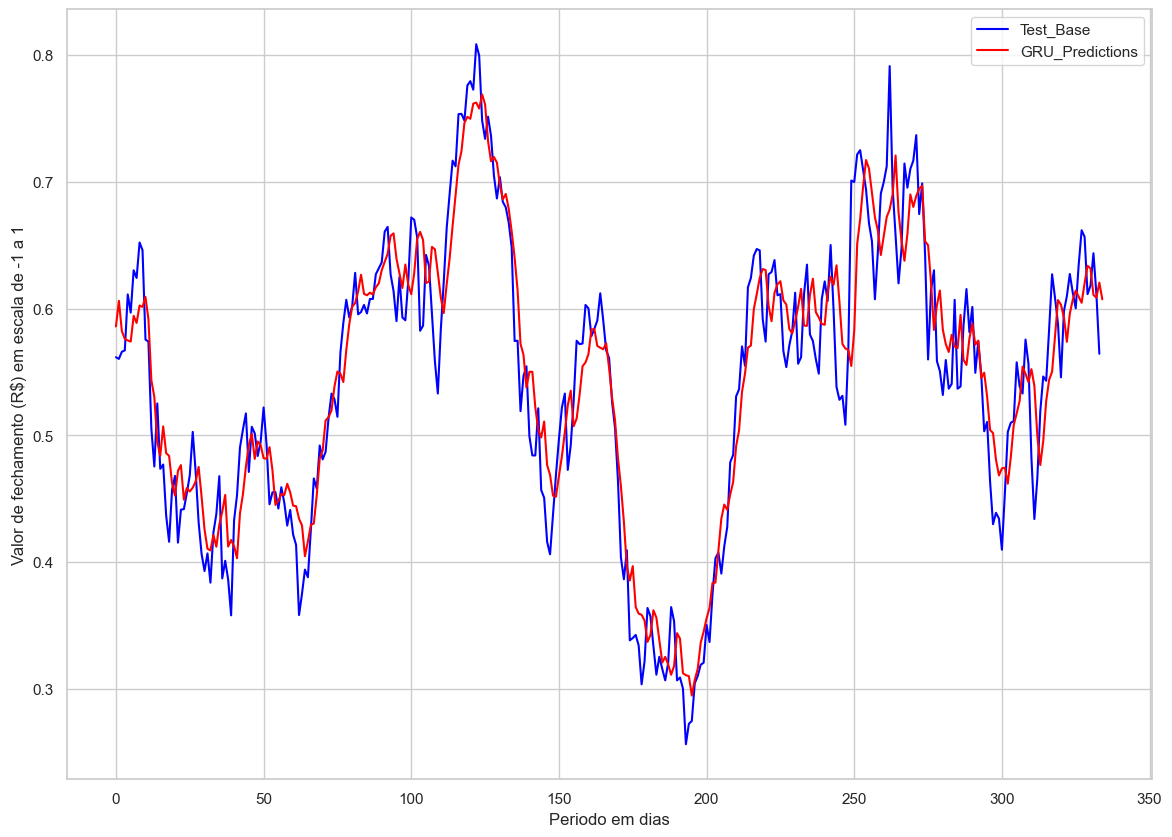

In [113]:
y_pred = model_gru.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test_Base')
plt.plot(y_pred, color = 'red', label = 'GRU_Predictions')
plt.xlabel('Periodo em dias')
plt.ylabel('Valor de fechamento (R$) em escala de -1 a 1')
plt.legend()
plt.show()

In [64]:
y_test.shape, y_pred.shape

((330, 1), (330, 1))

In [65]:
y_test = y_test[:-1]
y_pred = y_pred[:-1]

In [66]:
MAE(y_test,y_pred), MAPE(y_test, y_pred), RMSE(y_test, y_pred)

(0.03156138596930449, 6.107501233432539, 0.03868159208727746)

#### LSTM

In [67]:
n_neurons = 256
n_batch_size = 32
dropout = 0.1
pass_days = 50

In [68]:
backcandles = pass_days
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for k in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[k-backcandles:k, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

11/11 [==============================] - 2s 183ms/step


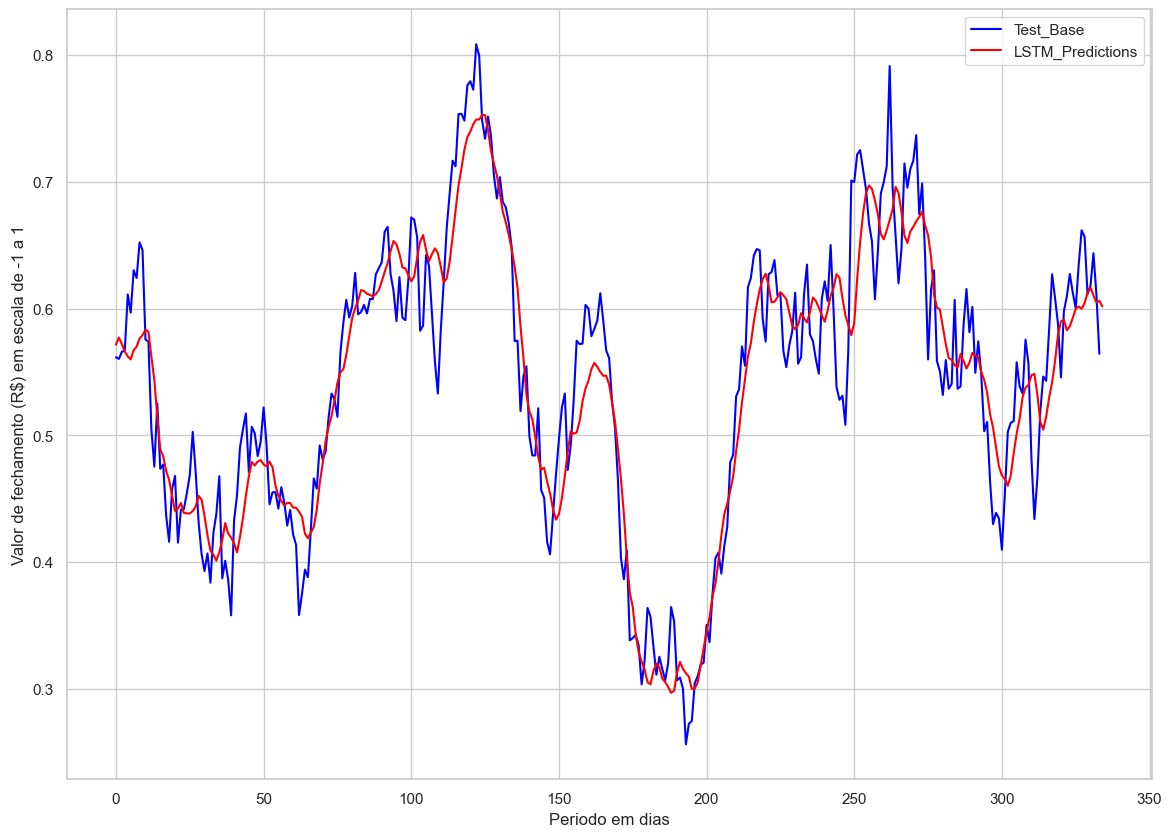

In [114]:
y_pred = model_lstm.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test_Base')
plt.plot(y_pred, color = 'red', label = 'LSTM_Predictions')
plt.xlabel('Periodo em dias')
plt.ylabel('Valor de fechamento (R$) em escala de -1 a 1')
plt.legend()
plt.show()

In [70]:
y_test.shape, y_pred.shape

((335, 1), (335, 1))

In [71]:
y_test = y_test[:-1]
y_pred = y_pred[:-1]

In [72]:
MAE(y_test,y_pred), MAPE(y_test, y_pred), RMSE(y_test, y_pred)

(0.03274997132061833, 6.1770836861535035, 0.04080000524072987)

### Making the predictions

In [73]:
bova11.reset_index(drop = True, inplace = True)

In [74]:
bova11_backup = bova11.copy()

In [75]:
bova11 = bova11[:-5]

In [76]:
pred_1_gru = predict(bova11, 1, 100, model_gru)
pred_1_lstm = predict(bova11, 1, 50, model_lstm)

pred_5_gru = predict(bova11, 5, 100, model_gru)
pred_5_lstm = predict(bova11, 5, 50, model_lstm)

pred_30_gru = predict(bova11, 30, 100, model_gru)
pred_30_lstm = predict(bova11, 30, 50, model_lstm)

pred_90_gru = predict(bova11, 90, 100, model_gru)
pred_90_lstm = predict(bova11, 90, 50, model_lstm)


1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13667.17it/s]


1
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12945.68it/s]


1
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13357.32it/s]


5
1/1 [==============================] - 0s 58ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13589.00it/s]


4
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10299.31it/s]


3
1/1 [==============================] - 0s 63ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9565.47it/s] 


2
1/1 [==============================] - 0s 64ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9274.56it/s] 


1
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10456.06it/s]


5
1/1 [==============================] - 0s 66ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10989.11it/s]


4
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9990.36it/s] 


3
1/1 [==============================] - 0s 42ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12205.30it/s]


2
1/1 [==============================] - 0s 47ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11139.25it/s]


1
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11817.56it/s]


30
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12817.69it/s]


29
1/1 [==============================] - 0s 63ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12573.60it/s]


28
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12593.81it/s]


27
1/1 [==============================] - 0s 73ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13068.92it/s]


26
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13529.70it/s]


25
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13607.38it/s]


24
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12919.64it/s]


23
1/1 [==============================] - 0s 71ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12138.67it/s]


22
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12345.41it/s]


21
1/1 [==============================] - 0s 61ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12141.53it/s]


20
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12035.36it/s]


19
1/1 [==============================] - 0s 81ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14053.94it/s]


18
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14400.59it/s]


17
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14150.58it/s]


16
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14166.16it/s]


15
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14834.37it/s]


14
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14148.77it/s]


13
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12148.56it/s]


12
1/1 [==============================] - 0s 71ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8667.37it/s]


11
1/1 [==============================] - 0s 90ms/step


100%|██████████| 3399/3399 [00:00<00:00, 5630.37it/s]


10
1/1 [==============================] - 0s 100ms/step


100%|██████████| 3399/3399 [00:00<00:00, 4998.58it/s]


9
1/1 [==============================] - 0s 120ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9197.51it/s]


8
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12128.64it/s]


7
1/1 [==============================] - 0s 58ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8040.20it/s] 


6
1/1 [==============================] - 0s 130ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6871.63it/s]


5
1/1 [==============================] - 0s 105ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8191.91it/s]


4
1/1 [==============================] - 0s 67ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11934.58it/s]


3
1/1 [==============================] - 0s 100ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9571.87it/s]


2
1/1 [==============================] - 0s 90ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6298.56it/s]


1
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14304.80it/s]


30
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8295.88it/s]


29
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12171.45it/s]


28
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9442.94it/s]


27
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8722.92it/s]


26
1/1 [==============================] - 0s 85ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6597.46it/s]


25
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9857.23it/s] 


24
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14786.15it/s]


23
1/1 [==============================] - 0s 90ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6470.72it/s]


22
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6533.40it/s] 


21
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10672.42it/s]


20
1/1 [==============================] - 0s 121ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7078.97it/s]


19
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10958.75it/s]


18
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7850.24it/s] 


17
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11540.20it/s]


16
1/1 [==============================] - 0s 39ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13332.14it/s]


15
1/1 [==============================] - 0s 90ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8285.32it/s]


14
1/1 [==============================] - 0s 75ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8084.39it/s]


13
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11519.05it/s]


12
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8176.06it/s]


11
1/1 [==============================] - 0s 71ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9457.67it/s]


10
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14458.14it/s]


9
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7060.40it/s]


8
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7234.93it/s]


7
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7388.10it/s]


6
1/1 [==============================] - 0s 41ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10004.20it/s]


5
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14153.11it/s]


4
1/1 [==============================] - 0s 54ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14167.88it/s]


3
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7893.09it/s] 


2
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9192.01it/s]


1
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9849.53it/s] 


90
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 4120.04it/s]


89
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6892.12it/s]


88
1/1 [==============================] - 0s 89ms/step


100%|██████████| 3399/3399 [00:00<00:00, 4503.74it/s]


87
1/1 [==============================] - 0s 104ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9859.72it/s] 


86
1/1 [==============================] - 0s 90ms/step


100%|██████████| 3399/3399 [00:00<00:00, 8942.61it/s]


85
1/1 [==============================] - 0s 135ms/step


100%|██████████| 3399/3399 [00:00<00:00, 4994.36it/s]


84
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 7912.63it/s]


83
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12501.91it/s]


82
1/1 [==============================] - 0s 110ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6123.98it/s]


81
1/1 [==============================] - 0s 120ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6065.24it/s]


80
1/1 [==============================] - 0s 85ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9444.05it/s]


79
1/1 [==============================] - 0s 68ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13081.62it/s]


78
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12702.29it/s]


77
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12401.11it/s]


76
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11057.97it/s]


75
1/1 [==============================] - 0s 52ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13079.75it/s]


74
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10976.23it/s]


73
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11148.09it/s]


72
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9169.84it/s] 


71
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11809.60it/s]


70
1/1 [==============================] - 0s 72ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11323.36it/s]


69
1/1 [==============================] - 0s 72ms/step


100%|██████████| 3399/3399 [00:00<00:00, 4668.47it/s]


68
1/1 [==============================] - 0s 85ms/step


100%|██████████| 3399/3399 [00:00<00:00, 6286.44it/s]


67
1/1 [==============================] - 0s 140ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9246.16it/s]


66
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11498.50it/s]


65
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13066.87it/s]


64
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13082.89it/s]


63
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14115.26it/s]


62
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12929.94it/s]


61
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11298.08it/s]


60
1/1 [==============================] - 0s 67ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10956.96it/s]


59
1/1 [==============================] - 0s 66ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10105.72it/s]


58
1/1 [==============================] - 0s 67ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13764.10it/s]


57
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12473.36it/s]


56
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14769.96it/s]


55
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11922.60it/s]


54
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14005.81it/s]


53
1/1 [==============================] - 0s 73ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13865.97it/s]


52
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14804.27it/s]


51
1/1 [==============================] - 0s 75ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14161.49it/s]


50
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14777.52it/s]


49
1/1 [==============================] - 0s 52ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11249.73it/s]


48
1/1 [==============================] - 0s 67ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10049.46it/s]


47
1/1 [==============================] - 0s 58ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11659.73it/s]


46
1/1 [==============================] - 0s 80ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10786.11it/s]


45
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10464.71it/s]


44
1/1 [==============================] - 0s 58ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12705.52it/s]


43
1/1 [==============================] - 0s 85ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11136.86it/s]


42
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13658.38it/s]


41
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14145.37it/s]


40
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13386.55it/s]


39
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14207.41it/s]


38
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13115.91it/s]


37
1/1 [==============================] - 0s 61ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14407.47it/s]


36
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11729.16it/s]


35
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15153.53it/s]


34
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12584.36it/s]


33
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15265.75it/s]


32
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12732.77it/s]


31
1/1 [==============================] - 0s 52ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15001.68it/s]


30
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12371.93it/s]


29
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14210.41it/s]


28
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13123.42it/s]


27
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13942.86it/s]


26
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14148.23it/s]


25
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12451.92it/s]


24
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14786.89it/s]


23
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14178.98it/s]


22
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13360.77it/s]


21
1/1 [==============================] - 0s 75ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9562.33it/s]


20
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11043.60it/s]


19
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10277.04it/s]


18
1/1 [==============================] - 0s 66ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9994.45it/s] 


17
1/1 [==============================] - 0s 74ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12260.69it/s]


16
1/1 [==============================] - 0s 73ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11905.95it/s]


15
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12179.02it/s]


14
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13385.25it/s]


13
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12838.39it/s]


12
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13083.60it/s]


11
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11405.88it/s]


10
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14517.11it/s]


9
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13081.56it/s]


8
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14749.30it/s]


7
1/1 [==============================] - 0s 73ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12333.26it/s]


6
1/1 [==============================] - 0s 61ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14107.05it/s]


5
1/1 [==============================] - 0s 66ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13706.89it/s]


4
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14464.79it/s]


3
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14509.31it/s]


2
1/1 [==============================] - 0s 61ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13071.94it/s]


1
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14433.63it/s]


90
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14958.00it/s]


89
1/1 [==============================] - 0s 39ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13575.62it/s]


88
1/1 [==============================] - 0s 44ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14496.43it/s]


87
1/1 [==============================] - 0s 52ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14433.70it/s]


86
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14783.59it/s]


85
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12152.81it/s]


84
1/1 [==============================] - 0s 42ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13890.49it/s]


83
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11499.20it/s]


82
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9507.06it/s] 


81
1/1 [==============================] - 0s 57ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12360.71it/s]


80
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9583.01it/s]


79
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12680.82it/s]


78
1/1 [==============================] - 0s 56ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12587.32it/s]


77
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9545.35it/s] 


76
1/1 [==============================] - 0s 43ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15187.88it/s]


75
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12606.34it/s]


74
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15032.30it/s]


73
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12601.53it/s]


72
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14766.79it/s]


71
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12921.56it/s]


70
1/1 [==============================] - 0s 43ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11650.56it/s]


69
1/1 [==============================] - 0s 48ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12239.77it/s]


68
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10467.02it/s]


67
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12589.89it/s]


66
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14887.46it/s]


65
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13728.43it/s]


64
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14807.39it/s]


63
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13238.59it/s]


62
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13820.33it/s]


61
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13580.95it/s]


60
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15412.63it/s]


59
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12692.89it/s]


58
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14779.64it/s]


57
1/1 [==============================] - 0s 37ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12841.35it/s]


56
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14931.74it/s]


55
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 15475.54it/s]


54
1/1 [==============================] - 0s 38ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14374.08it/s]


53
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10684.39it/s]


52
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11127.70it/s]


51
1/1 [==============================] - 0s 62ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9706.90it/s]


50
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11917.10it/s]


49
1/1 [==============================] - 0s 53ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12500.46it/s]


48
1/1 [==============================] - 0s 70ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12536.69it/s]


47
1/1 [==============================] - 0s 65ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10649.11it/s]


46
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12574.32it/s]


45
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13168.41it/s]


44
1/1 [==============================] - 0s 41ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12227.27it/s]


43
1/1 [==============================] - 0s 49ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13308.96it/s]


42
1/1 [==============================] - 0s 38ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12362.66it/s]


41
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14284.37it/s]


40
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13199.73it/s]


39
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13932.86it/s]


38
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13604.41it/s]


37
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13592.98it/s]


36
1/1 [==============================] - 0s 41ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12904.23it/s]


35
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14160.43it/s]


34
1/1 [==============================] - 0s 43ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13074.84it/s]


33
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14443.44it/s]


32
1/1 [==============================] - 0s 39ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13420.45it/s]


31
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14475.64it/s]


30
1/1 [==============================] - 0s 43ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12097.78it/s]


29
1/1 [==============================] - 0s 39ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13600.59it/s]


28
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12809.34it/s]


27
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14173.54it/s]


26
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13033.64it/s]


25
1/1 [==============================] - 0s 39ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13987.38it/s]


24
1/1 [==============================] - 0s 46ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12844.12it/s]


23
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12286.31it/s]


22
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10005.73it/s]


21
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12783.74it/s]


20
1/1 [==============================] - 0s 59ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11111.01it/s]


19
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11721.77it/s]


18
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12926.15it/s]


17
1/1 [==============================] - 0s 60ms/step


100%|██████████| 3399/3399 [00:00<00:00, 9703.78it/s] 


16
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14763.61it/s]


15
1/1 [==============================] - 0s 42ms/step


100%|██████████| 3399/3399 [00:00<00:00, 10617.80it/s]


14
1/1 [==============================] - 0s 44ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14158.65it/s]


13
1/1 [==============================] - 0s 45ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12261.59it/s]


12
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13859.91it/s]


11
1/1 [==============================] - 0s 40ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12138.13it/s]


10
1/1 [==============================] - 0s 41ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14161.80it/s]


9
1/1 [==============================] - 0s 46ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12292.14it/s]


8
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14284.79it/s]


7
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 11583.14it/s]


6
1/1 [==============================] - 0s 51ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14213.98it/s]


5
1/1 [==============================] - 0s 55ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12595.89it/s]


4
1/1 [==============================] - 0s 46ms/step


100%|██████████| 3399/3399 [00:00<00:00, 13453.68it/s]


3
1/1 [==============================] - 0s 42ms/step


100%|██████████| 3399/3399 [00:00<00:00, 12665.24it/s]


2
1/1 [==============================] - 0s 50ms/step


100%|██████████| 3399/3399 [00:00<00:00, 14783.90it/s]

1


### Error metrics Calc

#### 1 day

In [77]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_1_gru_scaled = scaler.fit_transform(pred_1_gru)

scaler = MinMaxScaler(feature_range = (-1, 1))
pred_1_lstm_scaled = scaler.fit_transform(pred_1_lstm)

y_pred_1_gru = np.array([pred_1_gru_scaled[-1][3]])
y_pred_1_lstm = np.array([pred_1_lstm_scaled[-1][3]])
y_test_1 = np.array([bova11_scaled[-1][3]])

In [101]:
MAPE(y_pred_1_gru, y_test_1), MAE(y_pred_1_gru, y_test_1), RMSE(y_pred_1_gru, y_test_1)

(10.95189813320365, 0.0694134861303013, 0.0694134861303013)

In [79]:
MAPE(y_pred_1_lstm, y_test_1), MAE(y_pred_1_lstm, y_test_1), RMSE(y_pred_1_lstm, y_test_1)

(7.857298972960962, 0.04812729657417947, 0.04812729657417947)

#### 5 days

In [80]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_5_gru_scaled = scaler.fit_transform(pred_5_gru)
pred_5_lstm_scaled = scaler.fit_transform(pred_5_lstm)

y_pred_5_gru = []
y_pred_5_lstm = []
y_test_5 = []

for i in range (5):
    y_pred_5_gru.append(pred_5_gru_scaled[-5:][i][3])
    y_pred_5_lstm.append(pred_5_lstm_scaled[-5:][i][3])
    y_test_5.append(bova11_scaled[-5:][i][3])
    
y_pred_5_gru = np.array(y_pred_5_gru)
y_pred_5_lstm = np.array(y_pred_5_lstm)
y_test_5 = np.array(y_test_5)

y_test_5, y_pred_5_gru, y_pred_5_lstm

(array([0.6114222 , 0.61814103, 0.64367293, 0.6114222 , 0.56438976]),
 array([0.61423677, 0.60699648, 0.60550183, 0.60306031, 0.60072005]),
 array([0.59980816, 0.59355044, 0.59057462, 0.58599418, 0.58057791]))

In [81]:
MAPE(y_pred_5_gru, y_test_5), MAE(y_pred_5_gru, y_test_5), RMSE(y_pred_5_gru, y_test_5)

(3.2065295922021395, 0.01936447969169528, 0.024408877047027582)

In [82]:
MAPE(y_pred_5_lstm, y_test_5), MAE(y_pred_5_lstm, y_test_5), RMSE(y_pred_5_lstm, y_test_5)

(4.439558213949253, 0.026183820208595242, 0.029891982568205865)

#### 30 days

In [83]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_30_gru_scaled = scaler.fit_transform(pred_30_gru)
pred_30_lstm_scaled = scaler.fit_transform(pred_30_lstm)

y_pred_30_gru = []
y_pred_30_lstm = []
y_test_30 = []

for i in range (30):
    y_pred_30_gru.append(pred_30_gru_scaled[-30:][i][3])
    y_pred_30_lstm.append(pred_30_lstm_scaled[-30:][i][3])
    y_test_30.append(bova11_scaled[-30:][i][3])
    
y_pred_30_gru = np.array(y_pred_30_gru)
y_pred_30_lstm = np.array(y_pred_30_lstm)
y_test_30 = np.array(y_test_30)

In [84]:
MAPE(y_pred_30_gru, y_test_30), MAE(y_pred_30_gru, y_test_30), RMSE(y_pred_30_gru, y_test_30)

(7.499866302125267, 0.04137603933662085, 0.050602993522825976)

In [85]:
MAPE(y_pred_30_lstm, y_test_30), MAE(y_pred_30_lstm, y_test_30), RMSE(y_pred_30_lstm, y_test_30)

(8.91859215928004, 0.04772425849902066, 0.05345145783314235)

### 90 days

In [86]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_90_gru_scaled = scaler.fit_transform(pred_90_gru)
pred_90_lstm_scaled = scaler.fit_transform(pred_90_lstm)

y_pred_90_gru = []
y_pred_90_lstm = []
y_test_90 = []

for i in range (90):
    y_pred_90_gru.append(pred_90_gru_scaled[-90:][i][3])
    y_pred_90_lstm.append(pred_90_lstm_scaled[-90:][i][3])
    y_test_90.append(bova11_scaled[-90:][i][3])
    
y_pred_90_gru = np.array(y_pred_90_gru)
y_pred_90_lstm = np.array(y_pred_90_lstm)
y_test_90 = np.array(y_test_90)

In [87]:
MAPE(y_pred_90_gru, y_test_90), MAE(y_pred_90_gru, y_test_90), RMSE(y_pred_90_gru, y_test_90)

(10.175206224384572, 0.05583180853594969, 0.06857055269248746)

In [88]:
MAPE(y_pred_90_lstm, y_test_90), MAE(y_pred_90_lstm, y_test_90), RMSE(y_pred_90_lstm, y_test_90)

(44.74636743737714, 0.134542183339685, 0.183141020764531)

#### Generating visualizations

In [102]:
import plotly.express as px
import plotly.graph_objs as go

In [115]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'][-100:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_90_lstm['close'][-100:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_90_gru.close[-100:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [116]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'][-50:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_30_lstm['close'][-50:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_30_gru.close[-50:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [117]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'][-10:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_5_lstm['close'][-10:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_5_gru.close[-10:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [118]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'][-10:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_1_lstm['close'][-10:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_1_gru.close[-10:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [107]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,109.110001,109.150002,108.010002,108.449997,-0.660004,108.486666,108.491000,107.087600,105.573250,1.005667,...,3.157294,109.698331,107.275002,112.336505,101.838694,111.887839,99.258662,56.314016,-0.660004,107.900002
3395,108.889999,109.330002,107.879997,107.900002,-0.549995,108.593333,108.596001,107.135000,105.624616,1.053531,...,3.181591,110.143343,107.043323,112.474891,101.795109,111.987798,99.261433,54.687174,-0.989998,109.430000
3396,108.709999,109.430000,107.970001,109.430000,1.529999,109.326668,108.919000,107.330870,105.670000,1.044363,...,3.211480,112.082486,106.570850,112.425975,102.235764,112.092960,99.247041,58.279485,0.720001,110.650002
3397,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.123000,107.642273,105.774595,1.061239,...,3.189486,111.463175,108.870158,111.867206,103.417340,112.153568,99.395622,60.925992,1.650002,110.419998


In [122]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close_change'][-100:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_90_lstm['close_change'][-100:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_90_gru.close_change[-100:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Variação entre o fechamento e fechamento anterior em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [123]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close_change'][-50:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_30_lstm['close_change'][-50:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_30_gru.close_change[-50:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Variação entre o fechamento e fechamento anterior em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [124]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close_change'][-10:],
   name="Real")
)

fig.add_trace(go.Scatter(
   y=pred_5_lstm['close_change'][-10:],
   name="LSTM")
)

fig.add_trace(go.Scatter(
   y=pred_5_gru.close_change[-10:],
   name="GRU")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Variação entre o fechamento e fechamento anterior em R$",
    xaxis_title="periodo em dias",
   #legend_title="legend",
)
fig.show()

In [125]:
bova11.tail(20)

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
3379,107.169998,107.500000,105.760002,105.949997,-0.850006,105.126666,104.203000,104.481334,105.765818,2.322519,...,2.777003,109.533770,100.719561,110.122123,98.840545,111.319824,100.211813,52.564852,-1.220001,102.629997
3380,104.360001,104.449997,102.290001,102.629997,-3.320000,103.019999,104.360000,104.644000,105.767222,2.271622,...,2.803059,108.531545,97.508454,110.454930,98.833071,111.373340,100.161105,44.152421,-1.730003,100.480003
3381,103.000000,103.000000,100.349998,100.480003,-2.149994,101.676666,104.295000,104.777334,105.784528,2.328453,...,2.826969,103.867580,99.485752,110.700110,98.854558,111.438466,100.130590,39.739640,-2.519997,101.919998
3382,101.209999,102.180000,100.410004,101.919998,1.439995,102.223333,104.498000,105.031667,105.778846,2.082701,...,2.854244,106.049569,98.397096,111.079374,98.983960,111.487335,100.070358,43.772331,0.709999,104.269997
3383,102.540001,104.269997,101.830002,104.269997,2.349998,103.896665,104.917999,105.376667,105.792745,2.337640,...,2.880868,107.534596,100.258734,111.487971,99.265363,111.554480,100.031010,49.662462,1.729996,105.500000
3384,104.480003,105.800003,104.199997,105.500000,1.230003,105.039998,105.063999,105.700667,105.803800,2.948979,...,2.909023,106.382089,103.697907,111.816649,99.584685,111.621845,99.985755,52.455502,1.019997,105.349998
3385,104.940002,106.320000,104.680000,105.349998,-0.150002,106.010000,105.203999,105.964000,105.754898,2.462946,...,2.918330,108.042044,103.977955,111.828529,100.099471,111.591559,99.918237,52.077937,0.409996,107.180000
3386,104.849998,107.540001,104.720001,107.180000,1.830002,107.209999,105.488000,106.274000,105.769167,1.732637,...,2.947485,110.960359,103.459639,111.667018,100.880982,111.664137,99.874196,56.198950,2.330002,109.099998
3387,107.400002,109.099998,107.110001,109.099998,1.919998,108.180000,106.220000,106.556333,105.782341,1.493137,...,2.977922,110.104992,106.255008,111.770895,101.341772,111.738185,99.826496,60.059868,1.699997,108.260002
3388,108.500000,109.180000,106.940002,108.260002,-0.839996,108.236666,106.861000,106.718000,105.749565,1.386252,...,3.002245,109.987133,106.486200,111.846910,101.589090,111.754056,99.745075,57.676745,-0.239998,107.349998


In [112]:
pred_90_lstm.tail(20)

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose,prev_close
3379,107.169998,107.500000,105.760002,95.815662,0.075891,95.911040,96.145170,96.182399,98.204688,0.235388,...,96.379078,95.443002,99.182656,93.182143,109.932250,86.477126,7.297111,-11.354336,96.177686,95.739772
3380,104.360001,104.449997,102.290001,96.177686,0.362023,96.093112,96.163069,95.905400,97.932049,0.256658,...,96.585723,95.600502,99.193186,92.617614,109.122441,86.741656,13.402153,-8.182315,96.285989,95.815662
3381,103.000000,103.000000,100.349998,96.285989,0.108304,96.272368,96.204532,95.612994,97.665757,0.278377,...,96.449689,96.095047,99.352124,91.873864,108.328541,87.002974,15.192347,-6.714011,96.353430,96.177686
3382,101.209999,102.180000,100.410004,96.353430,0.067441,96.340339,96.191874,95.285067,97.406177,0.224715,...,96.438600,96.242078,99.702379,90.867754,107.552504,87.259849,16.346132,-4.856569,96.381598,96.285989
3383,102.540001,104.269997,101.830002,96.381598,0.028168,96.384952,96.095134,94.919105,97.156407,0.146539,...,96.451604,96.318301,100.181680,89.656530,106.812841,87.499973,16.852340,-6.158403,96.419828,96.353430
3384,104.480003,105.800003,104.199997,96.419828,0.038230,96.428663,96.019662,94.517101,96.915934,0.437385,...,96.532757,96.324568,100.709328,88.324873,106.107450,87.724419,17.577623,-8.060175,96.484562,96.381598
3385,104.940002,106.320000,104.680000,96.484562,0.064733,96.322324,95.926270,94.424512,96.686641,0.620105,...,96.776843,95.867805,100.641234,88.207789,105.448207,87.925075,18.861629,-8.455441,96.062582,96.419828
3386,104.849998,107.540001,104.720001,96.062582,-0.421979,95.925790,95.818059,94.336105,96.468017,0.717472,...,97.202305,94.649275,100.592208,88.080002,104.833440,88.102594,17.010773,-8.787416,95.230227,96.484562
3387,107.400002,109.099998,107.110001,95.230227,-0.832355,95.425956,95.600365,94.249582,96.258279,0.701611,...,96.555552,94.296360,100.556203,87.942961,104.254296,88.262261,14.088955,-12.169774,94.985059,96.062582
3388,108.500000,109.180000,106.940002,94.985059,-0.245169,95.032340,95.279391,94.164291,96.058744,0.786854,...,95.390326,94.674354,100.531968,87.796613,103.718945,88.398542,13.364516,-13.514941,94.881734,95.230227
